# Plot gridded severe hail days

### How the analysis grid was generated

In [1]:
from geog import generate_grids
import geopandas as gpd

conus = gpd.read_file("CONUS.shp")
#econus = gpd.read_file("econus.shp") #Reads in areas of CONUS east of the Rockies

conus = conus.to_crs("ESRI:102003")

grids, x_, y_ = generate_grids(conus, 80000, 'ESRI:102003', returnxy=True)

<AxesSubplot:>

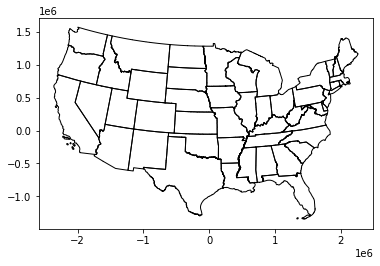

In [2]:
conus.plot(facecolor = 'none', edgecolor = 'k')

# Display the empty grids

<AxesSubplot:>

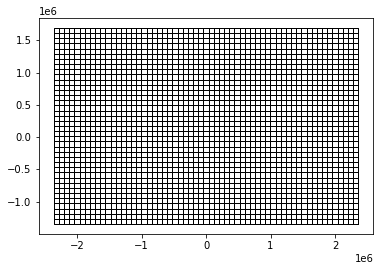

In [3]:
grids.plot(facecolor='none', edgecolor='k')

# Lats/Lons of grid

In [4]:
from geog import get_grid_mesh

gx, gy = get_grid_mesh(x_, y_)

gx

array([[-118.48174935, -117.73422743, -116.98395811, ...,  -75.0457756 ,
         -74.29539922,  -73.54776714],
       [-118.66304885, -117.90993837, -117.15401574, ...,  -74.87594291,
         -74.11991068,  -73.36668746],
       [-118.84723923, -118.0884618 , -117.32680545, ...,  -74.70338136,
         -73.9416128 ,  -73.18271996],
       ...,
       [-127.13890561, -126.13751477, -125.12914959, ...,  -66.91087945,
         -65.90224154,  -64.90057194],
       [-127.48169009, -126.47085048, -125.45281901, ...,  -66.58759682,
         -65.56928408,  -64.55815707],
       [-127.83181822, -126.81137952, -125.78352268, ...,  -66.25728643,
         -65.22913942,  -64.20840432]])

# Lats/Lons of WRF

In [5]:
import xarray as xr

geog = xr.open_dataset("/home/scratch/ahaberlie/simgeog/geo_em.d01.nc")

lons = geog.CLONG.values[0,:,:]
lats = geog.CLAT.values[0,:,:]

lons

array([[-121.81102 , -121.77783 , -121.74463 , ...,  -73.25537 ,
         -73.22217 ,  -73.188965],
       [-121.81999 , -121.786804, -121.7536  , ...,  -73.2464  ,
         -73.213196,  -73.17999 ],
       [-121.82898 , -121.79578 , -121.76254 , ...,  -73.23746 ,
         -73.20422 ,  -73.17102 ],
       ...,
       [-133.62482 , -133.57828 , -133.53171 , ...,  -61.468292,
         -61.421722,  -61.375183],
       [-133.64409 , -133.59752 , -133.55093 , ...,  -61.449066,
         -61.402466,  -61.355927],
       [-133.66338 , -133.61679 , -133.57019 , ...,  -61.42981 ,
         -61.38321 ,  -61.33661 ]], dtype=float32)

# Read in WRF HIST convective daily max .nc file

In [6]:
daily_max_hail = xr.open_dataset("/home/scratch/jgoodin/convective_daily_max_resamples/hist_daily_max_hail_inches.nc")

daily_max_hail #Resampled to daily max (12z - 12z) HAIL_MAX2D size for each day and grid cell

<xarray.Dataset>
Dimensions:     (Time: 5479, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-09-30T12:00:00 ... 2005-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 ...

In [7]:
year_test = daily_max_hail.sel(Time = '2000')

In [8]:
year_test

<xarray.Dataset>
Dimensions:     (Time: 366, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-12-31T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 ...

## Pass severe hail day threshold

In [9]:

sev_hail_days = 1*(year_test>0.0254) #Pass day threshold to this variable

#big_boy_day = sev_hail_days.sum(('south_north', 'west_east'))

#big_boy_day

In [10]:
sev_hail_days

<xarray.Dataset>
Dimensions:     (Time: 366, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-12-31T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0

In [ ]:
#big_boy_day.sortby('HAIL_MAX2D', ascending=False).Time.values[:25]

#### For loop basic layout

In [ ]:
"""
for dtime in year_test.Time:
    a = year_test.sel(Time = dtime)
    
    #regrid, save, etc
        
    #break
a
"""


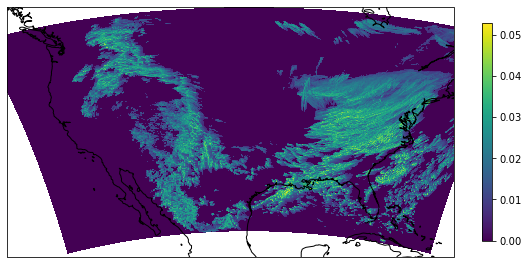

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 10, 10

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-130, -70, 20, 50])
ax.coastlines()

big_boy_day_test = daily_max_hail.sel(Time='2000-06-29T12:00:00.000000000')

mmp = ax.pcolormesh(lons, lats, big_boy_day_test['HAIL_MAX2D'].values, shading='nearest',
                    transform=ccrs.PlateCarree())

plt.colorbar(mmp, ax=ax, shrink=0.4)

In [12]:
big_boy_day_test

<xarray.Dataset>
Dimensions:     (south_north: 899, west_east: 1399)
Coordinates:
    Time        datetime64[ns] 2000-06-29T12:00:00
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (south_north, west_east) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [13]:
import os
import geopandas as gpd
from geog import generate_grids, generate_points, generate_count, generate_raster, transform_points
import xarray as xr
import datetime
from copy import deepcopy
import pandas as pd
import numpy as np
import multiprocessing


for dtime in year_test.Time:
    a = year_test.sel(Time = dtime)
    
    def make_dataset(data, data_time, variable_name, description, x, y,
                gridx, gridy, first_event_time=None, last_event_time=None):
    r"""Convert raw ndarray information into a xarray dataset with
    the specified metadata.

    Parameters
    ----------
    data: (X, Y) ndarray
        Raw geospatial data in numpy array form.
    data_time: datetime
        datetime representing the valid time for the input data.
    variable_name: string
        descriptive variable name associated with data.
    description: string
        A brief description of the data being saved. This will help
        you later when you are trying to figure out what is stored in
        these netCDF files.
    x: ndarray
        X coordinates associated with data.
    y: ndarray
        Y coordinates associated with data.
    gridx: (X, Y) ndarray
        Meshgrid x coordinates of transformed centers (e.g., albers to lons).
    gridy: (X, Y) ndarray
        Meshgrid y coordinates of transformed centers (e.g., albers to lats).
    first_event_time: datetime
        If keeping track of the date range for the analysis, the
        time of the first event. If None, will default to data_time.
    last_event_time: datetime
        If keeping track of the date range for the analysis, the
        time of the last event. If None, will default to data_time.

    Returns
    -------
    dset: xarray Dataset
        Dataset representation of the grid with a count column.
    """
    
        d_time = np.array([data_time])
        dset = xr.Dataset({variable_name: (('y', 'x', 'time'), np.expand_dims(data, 2)),
                       'lons': (('gy', 'gx'), gridx),
                       'lats': (('gy', 'gx'), gridy)},
                    coords={'y': (('y'), y),
                            'x': (('x'), x),
                            'time': (('time'), d_time)})

        dset.attrs['xy_projection'] = 'ESRI:102003'
        dset.attrs['description'] = description
    
        if first_event_time is not None:
            dset.attrs['First event'] = str(first_event_time)
        else:
            dset.attrs['First event'] = str(data_time)
        
        if last_event_time is not None:
            dset.attrs['First event'] = str(last_event_time)
        else:
            dset.attrs['Last event'] = str(data_time)

        return dset
    
    def process_period(ref_img, thresh, dtime, bbox, ilo, ila,
                   out_var_name, description, grid_size=80000, 
                   grid_proj='ESRI:102003'):
    r"""For each time period (hour, day, etc.), convert the ref_img
    grid counts into a larger grid count. This will count however
    many pixels in each grid exceed thresh.

    Parameters
    ----------
    ref_img: (X, Y) ndarray
        Reference image from which to gather qualifying grid cells
    thresh: numerical
        Qualifying cells should meet or exceed this value
    dtime: datetime
        The valid time of the ref_img
    bbox: GeoDataFrame
        The bounding geography for grid generation (e.g., lower 48
        shapefile)
    ilo: (X, Y) ndarray
        Longitude gridmesh associated with ref_img
    ila: (X, Y) ndarray
        Latitude gridmesh associated with ref_img
    grid_size: numeric
        Size of grid spacing in meters (Default 80,000 m)
    grid_proj: string
        Projection string (e.g., EPSG, ESRI, etc.) defining
        projection of the resulting grid. Default 'ESRI:102003',
        which is USA Contiguous Albers Equal Area Conic.

    Returns
    -------
    dset: xarray Dataset
        Dataset representation of the grid with a count column.
    """
    
        grids, x_, y_ = generate_grids(bbox, grid_size, grid_proj, returnxy=True)

        pts = np.where(ref_img >= thresh) #Where point meets thresh, save point

        y = [ila[y, x] for y, x in zip(pts[0], pts[1])] #Translate back to lat/lon
        x = [ilo[y, x] for y, x in zip(pts[0], pts[1])]

        pts = generate_points(x, y, in_crs='EPSG:4269', out_crs=grid_proj)
    
        counts = generate_count(grids, pts, no_match_nan=True) #Take points and cross ref with grid generated- geodataframe
    
        img, gx, gy = generate_raster(x_, y_, counts, from_crs=grid_proj, to_crs='EPSG:4269') #Create raster of above counts, take points and change back to lat/lon
    
        dset = make_dataset(data=img, data_time=dtime, variable_name=out_var_name, 
                        description=description, x=x_, y=y_, gridx=gx, gridy=gy) #Pass in information from above, save albers points and lat/lon mesh grid
    
        return dset
    
    test = process_period(ref_img=year_test['HAIL_MAX2D'].values, 
                      dtime=year_test.Time.values, 
                      thresh=0.0254, bbox=conus, ilo=lons, ila=lats, #WRF lons/lats
                      out_var_name='svr_hail_day', description='count of svr hail grids from wrf in each 80km grid') #Add what threshold was, when data was generated

    test.to_netcdf('/home/scratch/jgoodin/80km_hail_days/year_2000_test/' + a + '.nc')
    
    break
    
a
                      

<xarray.Dataset>
Dimensions:       (y: 38, x: 59, time: 1, gy: 38, gx: 59)
Coordinates:
  * y             (y) float64 -1.308e+06 -1.228e+06 ... 1.572e+06 1.652e+06
  * x             (x) float64 -2.322e+06 -2.242e+06 ... 2.238e+06 2.318e+06
  * time          (time) datetime64[ns] 2000-06-29T12:00:00
Dimensions without coordinates: gy, gx
Data variables:
    svr_hail_day  (y, x, time) float64 0.0 0.0 0.0 0.0 ... 0.0 8.0 32.0 112.0
    lons          (gy, gx) float64 -118.5 -117.7 -117.0 ... -66.26 -65.23 -64.21
    lats          (gy, gx) float64 23.21 23.38 23.55 23.7 ... 49.28 49.05 48.81
Attributes:
    xy_projection:  ESRI:102003
    description:    count of svr hail grids from wrf in each 80km grid
    First event:    2000-06-29T12:00:00.000000000
    Last event:     2000-06-29T12:00:00.000000000

In [ ]:
"""
plt.rcParams['figure.figsize'] = 40, 40
ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-130, -70, 20, 50])
ax.coastlines()

mmp = ax.pcolormesh(lons, lats, big_boy_day_test['HAIL_MAX2D'].values >= 0.0254, shading='nearest',
                    transform=ccrs.PlateCarree(), cmap='Greys')

plt.colorbar(mmp, ax=ax, shrink=0.5)

#ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
#ax.set_extent([-130, -70, 20, 50])
#ax.coastlines()

mmp = ax.pcolormesh(test.lons.values, test.lats.values, test.svr_hail_day.values[:,:,0] >= 1, shading='nearest',
                    transform=ccrs.PlateCarree(), alpha=0.4)

plt.colorbar(mmp, ax=ax, shrink=0.5)

#plt.savefig("test.png", dpi=300, bbox_inches='tight')
"""


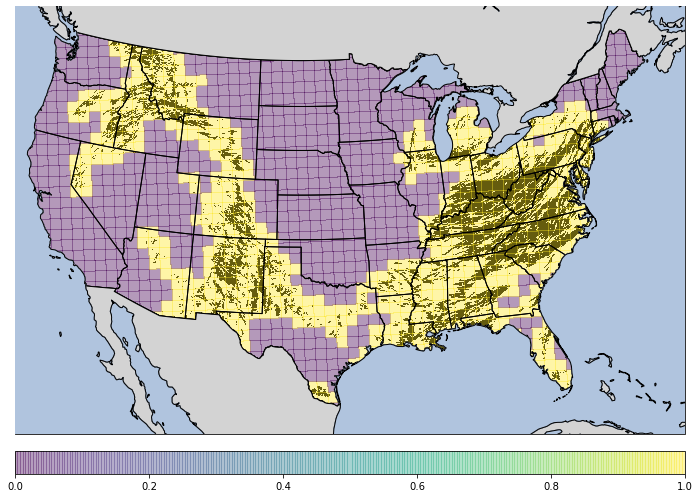

In [40]:
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

fig = plt.figure(figsize= (12,8)) #Plot a figure
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, .05], bottom=.05, top=.95, wspace=.1)
map_proj = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35) #Set projection, central lat/lon
ax = plt.subplot(projection = map_proj)
ax.set_extent([240,287,22,50])
ax.add_feature(cfeature.LAND.with_scale('10m')) #Add land
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_0_countries')
for country, info in zip(shpreader.Reader(countries_shp).geometries(), 
                             shpreader.Reader(countries_shp).records()):
        if info.attributes['NAME_LONG'] != 'United States':

            ax.add_geometries([country], ccrs.PlateCarree(),
                             facecolor='lightgrey', edgecolor='k', zorder=6)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='k', 
                                                facecolor='None'), zorder=8) 
ax.add_feature(cfeature.BORDERS.with_scale('10m')) #Add state borders
ax.add_feature(cfeature.STATES.with_scale('10m'), facecolor = 'none') #Add US states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', 
                                                facecolor='lightsteelblue'), zorder=6)
lakes_shp = shpreader.natural_earth(resolution='50m',
                                     category='physical',
                                     name='lakes')
for lake, info in zip(shpreader.Reader(lakes_shp).geometries(), 
                             shpreader.Reader(lakes_shp).records()):
        name = info.attributes['name']
        if name == 'Lake Superior' or name == 'Lake Michigan' or \
           name == 'Lake Huron' or name == 'Lake Erie' or name == 'Lake Ontario':
            
            ax.add_geometries([lake], ccrs.PlateCarree(),
                             facecolor='lightsteelblue', edgecolor='k', zorder=6)
lrFig = ax.pcolormesh(lons, lats, big_boy_day_test['HAIL_MAX2D'].values >= 0.0254, shading='nearest', 
                      cmap='Greys', transform=ccrs.PlateCarree())
              
#ax1 = plt.subplot(gs1[1, 0])
#cb = plt.colorbar(lrFig, cax = ax1, orientation = 'horizontal')

mmp = ax.pcolormesh(test.lons.values, test.lats.values, test.svr_hail_day.values[:,:,0] >= 1, shading='nearest', 
                    transform=ccrs.PlateCarree(), alpha=0.4)  
              
ax2 = plt.subplot(gs1[1, 0])  
cb1 = plt.colorbar(mmp, cax = ax2, orientation = 'horizontal')
plt.subplots_adjust(bottom=0.1)
